In [13]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio as disp_audio

In [2]:
SOUND_FILE = "no_role_modelz.wav"
IS_INSTRUMENTAL = False

Make the file in `.wav` format

In [4]:
# check if in mp3 format
if (ext:=SOUND_FILE.split('.')[-1]) in ['mp3', 'flv', 'ogg', 'raw']:

    # convert to wav
    sound = eval(f"AudioSegment.from_{ext}(SOUNDFILE)")
    os.system(f"rm {SOUND_FILE}")
    SOUND_NAME = SOUND_FILE.removesuffix(ext)
    sound.export(f"{SOUND_NAME}.wav", format="wav")

else:
    
    # change to just the name of the file
    SOUND_NAME = SOUND_FILE.removesuffix('.wav')

Show 30-second segment

In [10]:
song, rate = librosa.load(f'{SOUND_NAME}.wav')
disp_audio(data=song[100*rate:110*rate], rate=rate)

Generate instrumental of the track

In [11]:
# credit to https://github.com/tsurumeso/vocal-remover
if not IS_INSTRUMENTAL and f"{SOUND_NAME}_instr.wav" not in os.listdir():
    _ = os.system(f"./sep_instr.sh {SOUND_NAME}")
song, rate = librosa.load(f'{SOUND_NAME}_instr.wav')
disp_audio(data=song[100*rate:110*rate], rate=rate)

Display wavefile

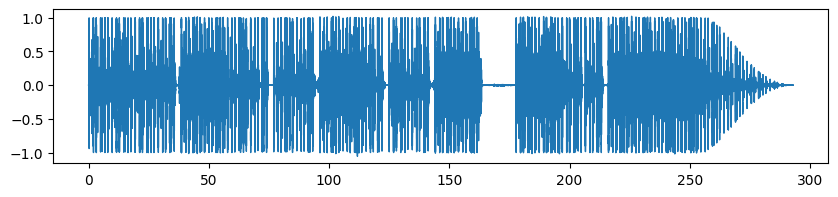

In [24]:
song, rate = librosa.load(f'{SOUND_NAME}_instr.wav')
time = np.arange(len(song[:]))/rate
fig = plt.gcf()
fig.set_size_inches(10, 2)
plt.plot(time, song[:], lw=1)